In [1]:
%matplotlib inline
import calendar
import configparser
import glob
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn

plt.style.use("ggplot")

# Get API key for HydAPI
config = configparser.RawConfigParser()
config.read(".nve-hydapi-key")
api_key = config.get("Auth", "key")

# Long-term trends in annual temperature

As part of reporting to Miljødirektoratet, Øyvind would like to estimate long-term trends in annual water temperature for the main rivers in Elveovervåkingsprogrammet. Based on NVE Atlas, the following temperature records are available:

In [2]:
stn_xlsx = r"../../../Data/temperature_data/long_term_trends/nve_temp_trends_stns.xlsx"
stn_df = pd.read_excel(stn_xlsx, sheet_name="Sheet1")
stn_df

,station_id,station_code,station_name,nve_id,nve_name,start
0,29617,ØSTEGLO,Glomma ved Sarpsfoss,2.1087.0,Glomma ovf. Sarpsfossen,2007-09-21
1,36225,OSLEALN,Alna,NaN,NaN,NaT
2,29612,BUSEDRA,Drammenselva,12.298.0,Drammenselva v/Døvikfoss,1986-12-09
3,29615,VESENUM,Numedalslågen,15.115.0,Numedalslågen v/Brufoss,1984-11-15
4,29613,TELESKI,Skienselva,16.207.0,Skienselva ndf. Norsjø,1966-10-13
5,30019,AAGEVEG,Vegårdselva,NaN,NaN,NaT
6,29614,VAGEOTR,Otra,21.79.0,Otra v/Mosby,1986-01-02
7,29832,ROGEBJE,Bjerkreimselva,27.29.0,Bjerkreimselvi v/Bjerkreim,1986-04-24
8,29783,ROGEORR,Orreelva,NaN,NaN,NaT
9,29837,ROGEVIK,Vikedalselva,38.2.0,Vikedalselva utløp,1985-10-13


Øyvind has suggested we consider those stations with records beginning **before 1995** (see e-mail received 29.10.2018 at 08.41 for details). I will attempt to download these directly using HydAPI. 

**Note:** We need to take care when calculating temperature averages from years with partial data (because the seasonal variation in temperature is obviously very strong). In the code below, I have created a user-defined parameter called `prop` which represents the proportion of the year that must have data in order to be included in the analysis. I've set this to 0.75 as a starting point i.e. there must be at least 274 ($= 0.75 \times 365$) non-null temperature measurements in a year for it to be included.

## 1. Search stations in HydAPI

In [3]:
# Final year of interest
year = 2020

# Proportion of year with daily values for year to be used in the analysis
prop = 0.9

# Output
png_fold = f"../../../Data/temperature_data/long_term_trends/to_{year}/png/prop_{int(prop*100)}"

# Output Excel file
out_xlsx = f"../../../Data/temperature_data/long_term_trends/to_{year}/long_term_temp_trends_prop_{int(prop*100)}.xlsx"

In [4]:
# Station with data before 1995
stn_df = stn_df.query("start < '1995-01-01'")

# Get stations from HydAPI
nve_stn_df = nivapy.da.get_nve_hydapi_stations(api_key=api_key)
nve_stn_ids = stn_df["nve_id"].tolist()
nve_stn_df = nve_stn_df.query("station_id in @nve_stn_ids")

print(f"{len(nve_stn_df)} out of {len(nve_stn_ids)} stations found in HydAPI.")
if len(nve_stn_df) != len(nve_stn_ids):
    not_found = set(nve_stn_ids) - set(nve_stn_df["station_id"].tolist())
    print("The following stations could not be identified:")
    print(not_found)

nve_stn_df

14 out of 14 stations found in HydAPI.


,station_id,station_name,latitude,longitude,utmEast_Z33,utmNorth_Z33,masl,riverName,councilNumber,councilName,...,culQ5,culQ10,culQ20,culQ50,culHm,culH5,culH10,culH20,culH50,seriesList
147,12.298.0,Drammenselva v/Døvikfoss kraftstasjon,59.88580,9.90887,215237,6649648,20,Drammensvassdraget,3047,Modum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
227,121.62.0,Orkla v/Merk bru,62.90437,9.80669,236297,6985584,204,Orkla,5022,Rennebu,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
351,15.115.0,Numedalslågen v/Brufoss,59.42728,9.99187,216019,6598328,51,Numedalslågen,3805,Larvik,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
386,151.32.0,Vefsna v/Laksfors,65.62244,13.29067,421282,7278897,44,Vefsna,1825,Grane,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
484,16.207.0,Skienselva ndf. Norsjø,59.20762,9.53179,187958,6575977,20,Skiensvassdraget,3807,Skien,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
704,196.43.0,Målselva ovf. Barduelva,69.03526,18.65517,645878,7662641,22,Målselvvassdraget,5418,Målselv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1013,21.79.0,Otra v/Mosby,58.20734,7.92995,84984,6473601,24,Otra,4204,Kristiansand,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1037,212.68.0,Altaelva v/Gargia,69.83170,23.48494,825580,7769785,46,Altavassdraget,5403,Alta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1093,234.19.0,Tana ovf. Polmakelva,70.07205,28.05574,993323,7827032,18,Tana,5441,Tana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."
1112,246.11.0,Pasvikelva v/Skogfoss kraftstasjon,69.37351,29.69533,1072959,7765252,40,Pasvikelva,5444,Sør-Varanger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'parameterName': 'Vanntemperatur', 'paramete..."


In [5]:
# Map
nivapy.spatial.quickmap(nve_stn_df, kartverket=True, popup="station_id")

## 2. Check data for current year

In [6]:
# Get temperature data for current year
par_ids = [1003]
st_dt = f"{year}-01-01"
end_dt = f"{year + 1}-01-01"

# Query in two batches to avoid API limit errors
df1 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[:7], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
df2 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[7:], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
nve_df = pd.concat([df1, df2], axis="rows")

nve_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,2020-01-01 11:00:00+00:00,4.287083,°C,0,2
1,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,2020-01-02 11:00:00+00:00,4.516459,°C,0,2
2,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,2020-01-03 11:00:00+00:00,4.087292,°C,0,2
3,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,2020-01-04 11:00:00+00:00,3.584583,°C,0,2
4,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,2020-01-05 11:00:00+00:00,3.359584,°C,0,2


In [7]:
# Check number of records as expected
days = 366 if calendar.isleap(year) else 365
if len(nve_df) != (len(nve_stn_df) * days):
    print("The number of records is not as expected.\n\n")

# Check for stations with no data
no_data = set(nve_stn_df["station_id"].tolist()) - set(nve_df["station_id"].tolist())
if len(no_data) > 0:
    print(f"The following stations have no temperature data for {year}:")
    print(stn_df.query("nve_id in @no_data"))

# Check quality control level
print(
    "\n\nThe following series have not completed quality control "
    "(i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):\n"
)
print(nve_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Check for NaN
if pd.isna(nve_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        nve_df[pd.isna(nve_df["value"])][
            ["station_id", "station_name"]
        ].drop_duplicates()
    )

The number of records is not as expected.


The following stations have no temperature data for 2020:
    station_id station_code    station_name   nve_id  \
7        29832      ROGEBJE  Bjerkreimselva  27.29.0   
11       29842      SFJENAU          Nausta  84.23.0   

                      nve_name      start  
7   Bjerkreimselvi v/Bjerkreim 1986-04-24  
11         Nausta v/Hovefossen 1989-12-07  


The following series have not completed quality control (i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):

     station_id                           station_name
0        38.2.0                     Vikedalselva utløp
366    16.207.0                 Skienselva ndf. Norsjø
732     62.30.0               Vosso ovf. Evangervatnet
1098    21.79.0                           Otra v/Mosby
1464   15.115.0                Numedalslågen v/Brufoss
1779   12.298.0  Drammenselva v/Døvikfoss kraftstasjon
0      246.11.0     Pasvikelva v/Skogfoss kraftstasjon
348    212.68.0   

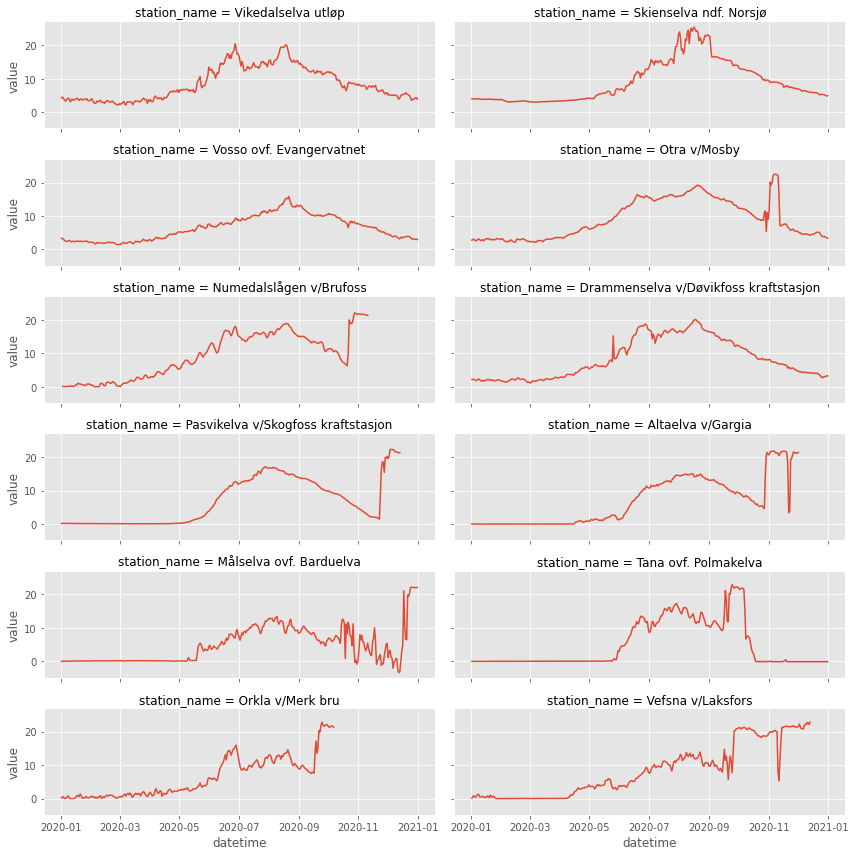

In [8]:
# Plot
sn.relplot(
    x="datetime",
    y="value",
    col="station_name",
    data=nve_df,
    kind="line",
    aspect=3,
    height=2,
    col_wrap=2,
)

## 3. Get data since 1980

In [9]:
# Get temperature data since 1980
par_ids = [1003]
st_dt = "1980-01-01"
end_dt = f"{year + 1}-01-01"

# Query in two batches to avoid API limit errors
df1 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[:7], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
df2 = nivapy.da.query_nve_hydapi(
    nve_stn_ids[7:], par_ids, st_dt, end_dt, resolution=1440, api_key=api_key
)
nve_df = pd.concat([df1, df2], axis="rows")

nve_df.head()

,station_id,station_name,parameter,parameter_name,parameter_name_eng,method,datetime,value,unit,correction,quality
0,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,1985-10-13 11:00:00+00:00,8.466944,°C,0,0
1,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,1985-10-14 11:00:00+00:00,8.924862,°C,0,0
2,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,1985-10-15 11:00:00+00:00,9.245000,°C,0,0
3,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,1985-10-16 11:00:00+00:00,9.297916,°C,0,0
4,38.2.0,Vikedalselva utløp,1003,Vanntemperatur,Water temperature,Mean,1985-10-17 11:00:00+00:00,9.175139,°C,0,0


In [10]:
# Check for stations with no data
no_data = set(nve_stn_df["station_id"].tolist()) - set(nve_df["station_id"].tolist())
if len(no_data) > 0:
    print(f"The following stations have no temperature data for {year}:")
    print(stn_df.query("nve_id in @no_data"))

# Check quality control level
print(
    "\n\nThe following series have not completed quality control "
    "(i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):\n"
)
print(nve_df.query("quality != 3")[["station_id", "station_name"]].drop_duplicates())

# Check for NaN
if pd.isna(nve_df["value"]).sum() > 0:
    print("\n\nThe following records contain NaN values:\n")
    print(
        nve_df[pd.isna(nve_df["value"])][
            ["station_id", "station_name"]
        ].drop_duplicates()
    )



The following series have not completed quality control (i.e. 'quality' < 3; see https://hydapi.nve.no/UserDocumentation/ for details):

      station_id                           station_name
0         38.2.0                     Vikedalselva utløp
12864    21.79.0                           Otra v/Mosby
33476   15.115.0                Numedalslågen v/Brufoss
43681    62.30.0               Vosso ovf. Evangervatnet
51057    27.29.0             Bjerkreimselvi v/Bjerkreim
67928   12.298.0  Drammenselva v/Døvikfoss kraftstasjon
75660   16.207.0                 Skienselva ndf. Norsjø
0       212.68.0                      Altaelva v/Gargia
14688   234.19.0                   Tana ovf. Polmakelva
25824   121.62.0                       Orkla v/Merk bru
37345   246.11.0     Pasvikelva v/Skogfoss kraftstasjon
48213   196.43.0                Målselva ovf. Barduelva
59757    84.23.0                    Nausta v/Hovefossen
70177   151.32.0                      Vefsna v/Laksfors


The following recor

## 4. Trend analysis

The code below loops over each daily resolution temperature file and performs the following calculations:

 1. Resample to annual resolution by taking the mean, and count the number of non-null measurements in each year.
 
 2. Filter out years with less than $(prop \times 365)$ data points
 
 3. Write the annual results to a new worksheet in an Excel file
 
 4. Perform the Mann-Kendall and Sen's Slope tests on the annual data and print summary results
 
 5. Plot the fitted Sen's slope against the raw data values and save the plot as a PNG.

In [11]:
# Prepare to write Excel workbook
writer = pd.ExcelWriter(out_xlsx)

# Min count based on prop
min_days = prop * 365

# Loop over data
for nve_id in nve_df['station_id'].unique():
    df = nve_df.query("station_id == @nve_id").copy()
    df = df.set_index("datetime")[["value"]]

    # Resample (counts and avgs)
    cnt_df = df.resample("A").count()
    avg_df = df.resample("A").mean()

    # Join
    df = avg_df.join(cnt_df, lsuffix="", rsuffix="_count")

    # Filter years with insufficient data
    df = df.query("value_count > @min_days")

    # Index to years
    df.index = df.index.year

    # Save to Excel
    df.to_excel(writer, sheet_name=nve_id)

    # Run stats
    print("###################################################################")
    print("Station:", nve_id)
    print("Results based on %s years with data" % len(df))
    print("###################################################################")

    # Mann-Kendall
    print("M-K test:")
    mk_df = nivapy.stats.mk_test(df, "value")
    print(mk_df)
    print("")

    # Sen's slope
    print("Sen's slope:")
    res_df, sen_df = nivapy.stats.sens_slope(df, value_col="value", index_col=df.index)
    print(res_df)
    print("###################################################################")
    print("")

    # Plot
    nivapy.plotting.plot_sens_slope(
        res_df, sen_df, ylabel="Avg. temp. (C)", title="Station %s" % nve_id
    )
    out_png = os.path.join(png_fold, "sens_slp_%s.png" % nve_id)
    plt.savefig(out_png, dpi=300)
    plt.close()
writer.save()

###################################################################
Station: 38.2.0
Results based on 31 years with data
###################################################################
M-K test:
                            description        value
var_s        Variance of test statistic  3461.666667
s                    M-K test statistic        125.0
z             Normalised test statistic     2.107556
p      p-value of the significance test     0.035069
trend        Type of trend (if present)   increasing

Sen's slope:
                                            description       value
sslp                              Median slope estimate    0.019857
icpt                                Estimated intercept    -32.0034
lb     Lower bound on slope estimate at specified alpha    0.000789
ub     Upper bound on slope estimate at specified alpha    0.035267
trend                        Type of trend (if present)  increasing
##############################################################